# Part 1. Preparation
## 1.1 Parameter Preparation

In [1]:
# Parameter Prepration
# Import necessary libraries
import os, time 
import itertools # used to create iterators for efficient looping
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# training parameters
batch_size = 128
lr = 0.0002
train_epoch = 20

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 1.2. Data Preparation

In [2]:
datas = np.float32(np.loadtxt(r'C:\Users\LW\Desktop\SDSC_UnsupervisedDL_Jan2019\Assignment\GAN\3_DCGAN_Eng1\imgvectors.txt'))
# Convert each dataset back to its original image size
# For convolution-related processing we usually need the original image size
datas = np.reshape(datas, [-1, 28, 28, 1])
# reshape datas to 28*28
# later we need to reshape the size to 16*16 for training purpose

## 1.3. Input Preparation

In this stage we reshape the image into some dimensions suitable for doing convolution or deconvolution.

In [3]:
# variables : input
# From 28x28 pixels => 16x16 pixels
x = tf.placeholder(tf.float32, shape=(None, 16, 16, 1)) # reshaped images
# A noise vector of 100 elements
z = tf.placeholder(tf.float32, shape=(None, 1, 1, 100)) # pass to generator

isTrain = tf.placeholder(dtype=tf.bool) # Used for batch normalization
# True for training
# False for evaluation

# here we use fixed latent vectors so that we can monitor the training progress better
# of course we can also use dynamic latent vectors
# Initialize 25 noise vectors with fixed value
# Use to monitor the training progress
# How results from the same 'ideas' can be improved via DCGAN training
fixed_z_ = np.random.normal(0, 1, (25, 1, 1, 100))
# np.random.normal(mu,sigma,size)

# Part 2. Build GAN
## 2.1. Define Leaky RelU activation function

In [4]:
# define LeakyRelu as the activation function for generator
def lrelu(x, th=0.2):
    return tf.maximum(th * x, x)

## 2.2. Define Generator
conv2d_transpose - Transposed Convolution or Fractinally Strided Convolution or Deconvolution. Its main purpose is to convert low-resolution image to high-resolution. IN other words, enlarge your image in a reasonable way.

In [5]:
# define the generator
def generator(x, isTrain=True, reuse=False):
    with tf.variable_scope('generator', reuse=reuse):

        # 1st hidden layer
        # size of x -> (?,1,1,100)
        conv1 = tf.layers.conv2d_transpose(x, 64, [4, 4], strides=(1, 1), padding='valid') # size = (?,4,4,64)
        lrelu1 = lrelu(tf.layers.batch_normalization(conv1, training=isTrain), 0.2)
        # 'conv2d_transpose' is used for deconvolution
        # training=True : data normalization using the current batch
        # training=False: data normalization using moving statistics

        # 2nd hidden layer
        conv2 = tf.layers.conv2d_transpose(lrelu1, 64, [4, 4], strides=(2, 2), padding='same') # size = (?,8,8,64)
        lrelu2 = lrelu(tf.layers.batch_normalization(conv2, training=isTrain), 0.2)

        # output layer
        conv3 = tf.layers.conv2d_transpose(lrelu2, 1, [4, 4], strides=(2, 2), padding='same') # size = (?,16,16,1)
        o = tf.nn.tanh(conv3)
        return o
    
# networks : generator
G_z = generator(z, isTrain)

## 2.3. Define Discriminator

In [7]:
# define the discriminator
def discriminator(x, isTrain=True, reuse=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # 1st hidden layer
        # size of x -> (?,16,16,1)
        conv1 = tf.layers.conv2d(x, 64, [4, 4], strides=(2, 2), padding='same') # size = (?,8,8,64)
        lrelu1 = lrelu(conv1, 0.2) # use LeakyRelu as the activation function
        
        # 2nd hidden layer
        conv2 = tf.layers.conv2d(lrelu1, 64, [4, 4], strides=(2, 2), padding='same') # size = (?,4,4,64)
        # use LeakyRelu as the activation function
        lrelu2 = lrelu(tf.layers.batch_normalization(conv2, training=isTrain), 0.2) 
        
        # output layer
        conv3 = tf.layers.conv2d(lrelu2, 1, [4, 4], strides=(1, 1), padding='valid') # size = (?,1,1,1)       
        o = tf.nn.sigmoid(conv3)
        return o, conv3
    
# networks : discriminator
D_real, D_real_logits = discriminator(x, isTrain) # for real data
D_fake, D_fake_logits = discriminator(G_z, isTrain, reuse=True) # for fake data


## 2.4. Visualization

In [8]:
# define a function for visual delivery
def show_result(num_epoch, show = False, save = False, path = 'result.png'):
    
    fixed_z_ = np.random.normal(0, 1, (25, 1, 1, 100))
    
    test_images = sess.run(G_z, {z: fixed_z_, isTrain: False})
    size_figure_grid = 5
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5)) # (5,5,(5,5))
    
    # loop over the 5-by-5 matrix to remove axis
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)): 
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(size_figure_grid*size_figure_grid): # 5-by-5
        i = k // size_figure_grid # row number
        j = k % size_figure_grid # column number
        ax[i, j].cla() # clear current axis
        ax[i, j].imshow(np.reshape(test_images[k], (16, 16)), cmap='gray') # each image is converted to 16-by-16
    
    # show image information on the image
    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

# Part 3. Train Autoencoder
## 3.1. Define D loss and G loss

In [9]:
# loss for each network
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real_logits, 
                                                                     labels=tf.ones([batch_size, 1, 1, 1])))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, 
                                                                     labels=tf.zeros([batch_size, 1, 1, 1])))

D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, 
                                                                labels=tf.ones([batch_size, 1, 1, 1])))

## 3.2. Define D optimization and G optimization

In [10]:
# trainable variables for each network
T_vars = tf.trainable_variables()
# separate variables belonging to discriminator and generator
D_vars = [var for var in T_vars if var.name.startswith('discriminator')]
G_vars = [var for var in T_vars if var.name.startswith('generator')]

# optimizer for each network
# 'tf.GraphKeys.UPDATE_OPS' is used below due to the previous use of batch normalization (isTrain)
# OPS: operations
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
    # run dependency
    # run the following two lines after 'tf.get_collection(tf.GraphKeys.UPDATE_OPS)'
    D_optim = tf.train.AdamOptimizer(lr, beta1=0.5).minimize(D_loss, var_list=D_vars)
    G_optim = tf.train.AdamOptimizer(lr, beta1=0.5).minimize(G_loss, var_list=G_vars)
    # beta1: beta1 controls the exponential decay rate for the first moment estimate 
    # (intrinsic formula for optimization)


## 3.3. Train GAN

training start!


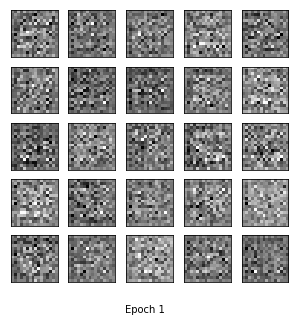

Processing epoch 0 .


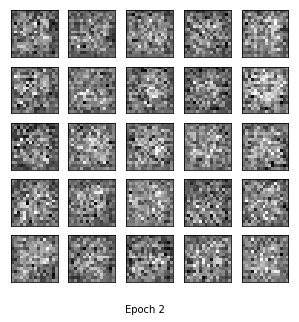

Processing epoch 1 .


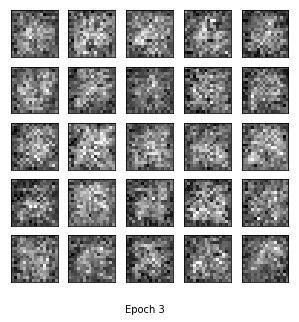

Processing epoch 2 .


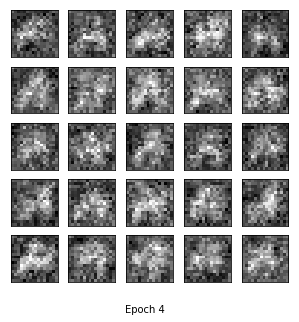

Processing epoch 3 .


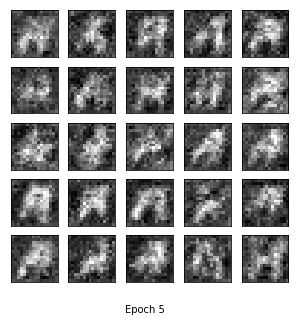

Processing epoch 4 .


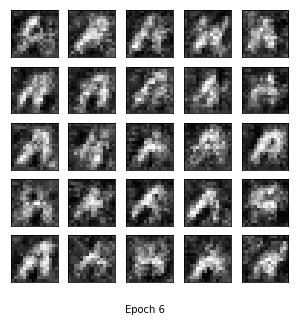

Processing epoch 5 .


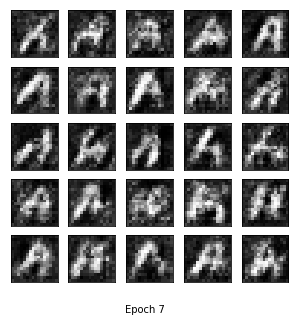

Processing epoch 6 .


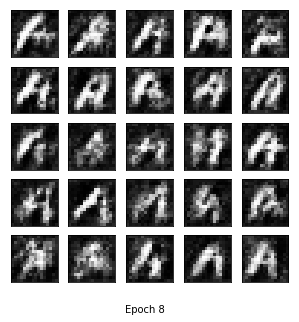

Processing epoch 7 .


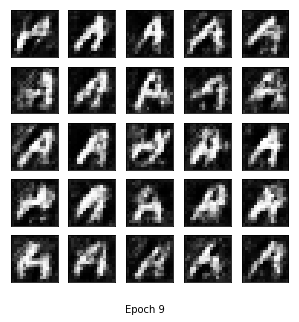

Processing epoch 8 .


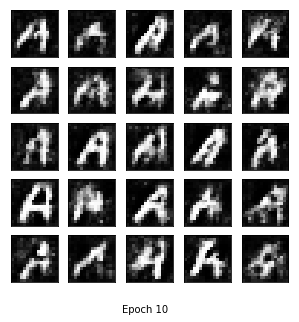

Processing epoch 9 .


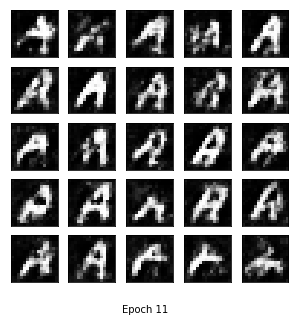

Processing epoch 10 .


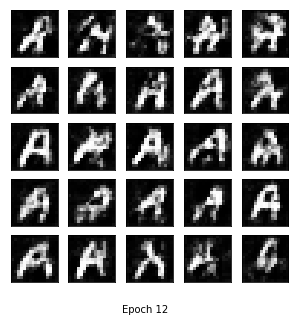

Processing epoch 11 .


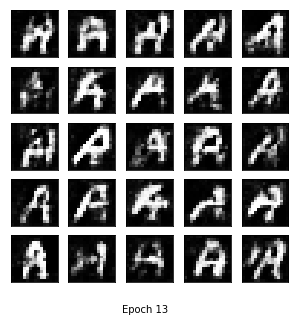

Processing epoch 12 .


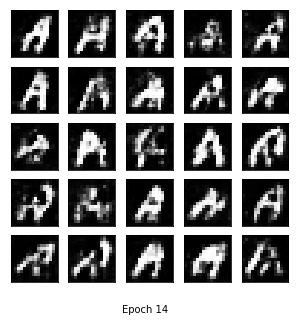

Processing epoch 13 .


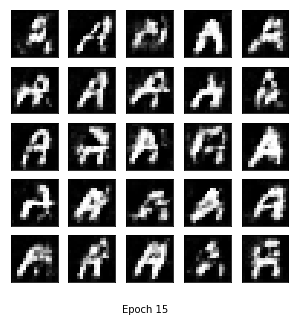

Processing epoch 14 .


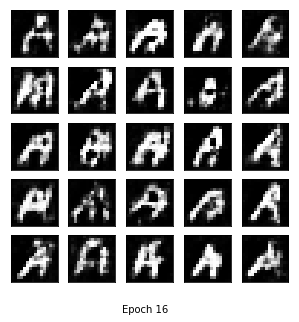

Processing epoch 15 .


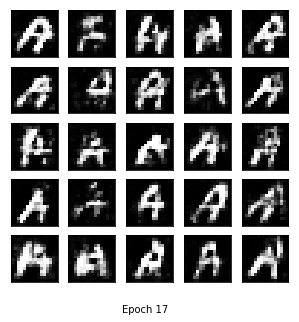

Processing epoch 16 .


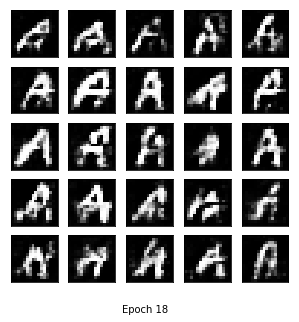

Processing epoch 17 .


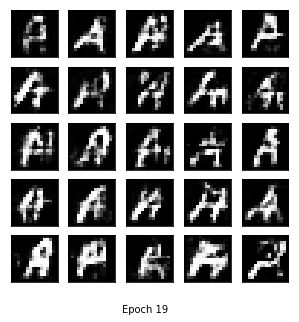

Processing epoch 18 .


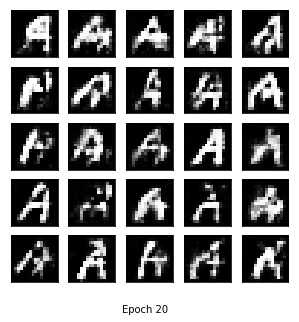

Processing epoch 19 .
Training finish!


In [11]:
# results save folder
root = 'DCGAN_results/'
model = 'DCGAN_'
if not os.path.isdir(root):
    os.mkdir(root)

print('training start!')

# open session 
sess = tf.InteractiveSession()
# InteractiveSession is for use in interactive context
# tf.InteractiveSession(): no need to define all operations
# tf.Session(): need to define all operations

# initialize variables
tf.global_variables_initializer().run()

train_set = tf.image.resize_images(datas, [16, 16]).eval() # eval() is a shortcut for sess.run(XXX)
train_set = (train_set - 0.5) / 0.5  # normalization; range: -1 ~ 1

for epoch in range(train_epoch):
    for iter in range(datas.shape[0]// batch_size):
        
        x_ = train_set[iter*batch_size:(iter+1)*batch_size]
        z_ = np.random.normal(0, 1, (batch_size, 1, 1, 100))
        # train generator
        sess.run(D_optim, {x: x_, z: z_, isTrain: True})

        z_ = np.random.normal(0, 1, (batch_size, 1, 1, 100))
        # update generator
        sess.run(G_optim, {z: z_, x: x_, isTrain: True})

    fixed_p = root + model + str(epoch + 1) + '.png'
    show_result((epoch + 1), show=True, save=False, path=fixed_p)
    print('Processing epoch',epoch,'.')
print("Training finish!")
sess.close()